In [1]:
import pandas as pd

In [2]:
%config IPCompleter.greedy=True

In [3]:
pd.set_option('display.max_columns', 25)
df = pd.read_csv('C:\Various Files\DataScience\ChicagoCrime\Crimes_2001_to_2018_clean.csv' )

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Updated_On'] = pd.to_datetime(df['Updated_On'])

In [5]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6007987 entries, 0 to 6007986
Data columns (total 22 columns):
Unnamed: 0              6007987 non-null int64
ID                      6007987 non-null int64
Case_Number             6007987 non-null object
Date                    6007987 non-null datetime64[ns]
Block                   6007987 non-null object
IUCR                    6007987 non-null object
Primary_Type            6007987 non-null object
Description             6007987 non-null object
Location_Description    6007987 non-null object
Arrest                  6007987 non-null bool
Domestic                6007987 non-null bool
Beat                    6007987 non-null int64
District                6007987 non-null int64
Ward                    6007987 non-null int64
Community_Area          6007987 non-null int64
FBI_Code                6007987 non-null object
X_Coordinate            6007987 non-null float64
Y_Coordinate            6007987 non-null float64
Updated_On             

In [6]:
df.shape

(6007987, 22)

In [7]:
df1 = df.set_index(df['Date'])

# 1. Changes of Crime Cases over Years
Question: Are there any trends or patterns from the time-series data on the number of cases over a period of time?

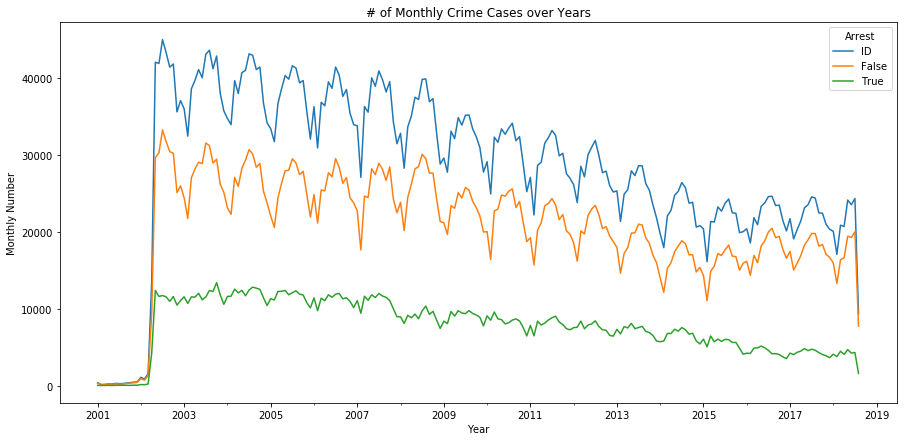

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
df1.resample('M').count()['ID'].plot(ax=ax, legend=True)
df1.groupby('Arrest').resample('M').count()['ID'].unstack(level=0).plot(ax=ax)
ax.set_title('# of Monthly Crime Cases over Years')
ax.set_xlabel('Year')
ax.set_ylabel('Monthly Number')
plt.show()

### 1.1 Check with Box Plot

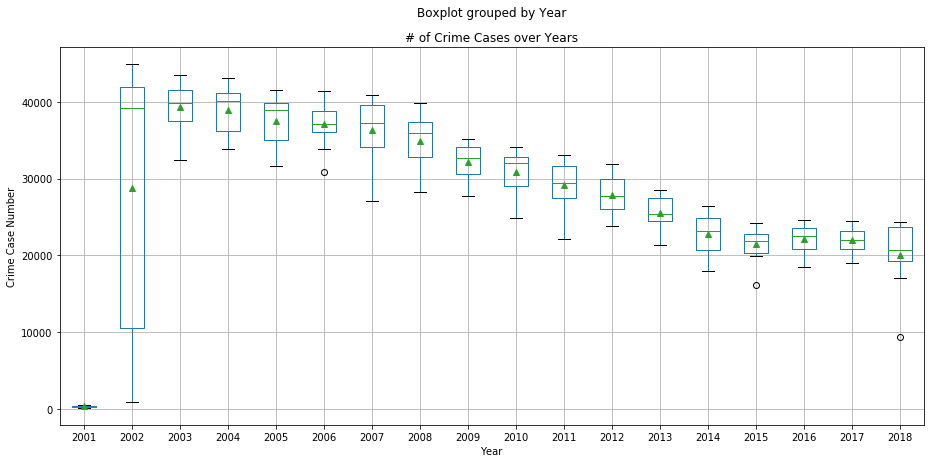

In [10]:
fig, ax = plt.subplots(figsize=(15,7))
df1['Year'] = df1.index.year
box_df1 = df1.resample('M').count()
box_df1['Year'] = box_df1.index.year
box_df1.boxplot(column='ID',by='Year', ax=ax, showmeans=True)
ax.set_title('# of Crime Cases over Years')
ax.set_xlabel('Year')
ax.set_ylabel('Crime Case Number')
plt.show()

### 1.2 Weekly Crime Cases 
Identify a pattern for the number change of weekly crime cases

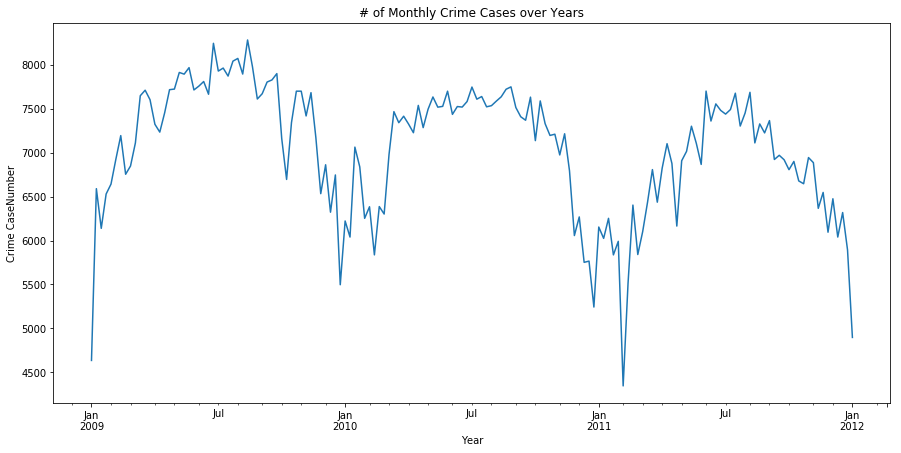

In [11]:
fig, ax = plt.subplots(figsize=(15,7))
df1.loc['2009':'2011'].resample('W').count()['ID'].plot(kind='line',ax=ax, legend=False)
ax.set_title('# of Monthly Crime Cases over Years')
ax.set_xlabel('Year')
ax.set_ylabel('Crime CaseNumber')
plt.show()

### 1.3 Conclusions
- The total number of crime cases is descreased over the years from 2003 to 2015
- The total number of crime cases stays the same between 2015 and 2018
- The number of not-arrested crime cases follows the change pattern of the total number of crime cases
- The number of arrested crime cases is descreased from 2003 to 2018
- From the box plot, the data in 2001 and 2002 are exceptional
- From the weekly plot, the number of crime cases drops to the lowest point around January or Februray each year
- From the weekly plot, the number of crime cases rises to the highest point aournd July each year


# 2. Block Distribution of Crime Cases
Question: What are the block distribution of crime cases and their top 20 locations?

In [12]:
top20_blocks = df1['ID'].groupby(df1['Block']).count().sort_values(ascending=False).head(20)
top20_block_coords = df1[df1['Block'].isin (top20_blocks.index)].loc[:,['Block','Latitude','Longitude']].drop_duplicates(subset='Block')

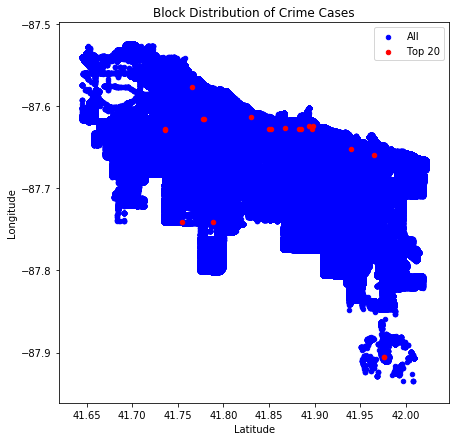

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
ax.set_title('Block Distribution of Crime Cases')
df1.plot(kind='scatter', x='Latitude', y='Longitude', ax=ax, color='Blue', label='All')
top20_block_coords.plot(kind='scatter', x='Latitude', y='Longitude', ax=ax, color='Red', label="Top 20")
plt.show()

### 2.1 Conclusions
- From the scatter charts, the top 20 blocks having the highest number of crime cases are almost all near the border of the city.

# 3. Crime Cases by Type
Question: which types/subtypes are among the highest number of crime cases?

### 3.1 By Primary Type Only

In [16]:
primary_type_df1 = df1['ID'].groupby(df1['Primary_Type']).count().sort_values(ascending=False).head(15)

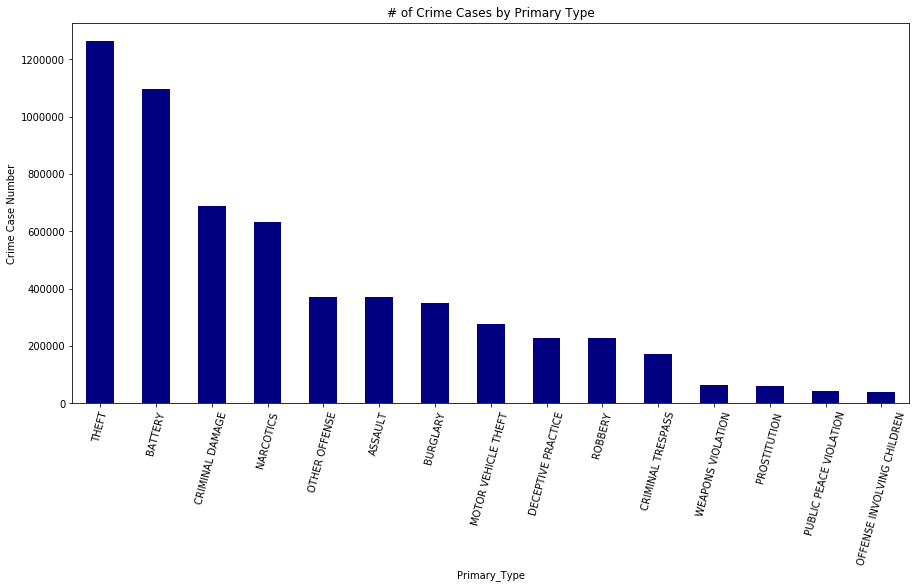

In [17]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('# of Crime Cases by Primary Type')
ax.set_xlabel('Primary Type')
ax.set_ylabel('Crime Case Number')
primary_type_df1.plot(kind='bar', rot=75, ax=ax, color='navy')

### 3.2 By Primary and Secondary Types

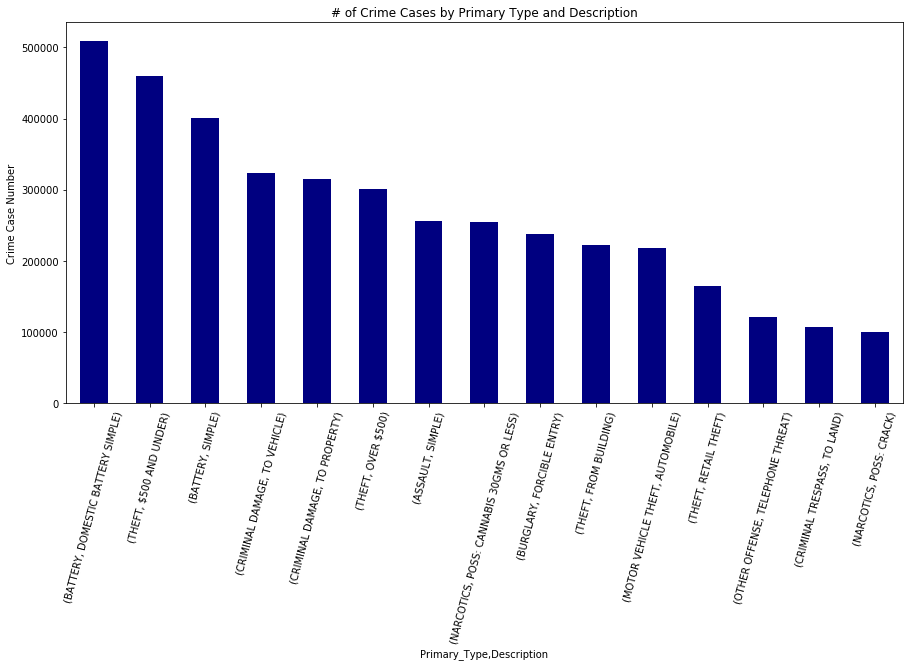

In [18]:
comb_type_df1 = df1.groupby(['Primary_Type', 'Description']).count().sort_values(by='ID',ascending=False).head(15)
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('# of Crime Cases by Primary Type and Description')
ax.set_xlabel('Primary Type and Description')
ax.set_ylabel('Crime Case Number')
comb_type_series = comb_type_df1['ID']
comb_type_series.plot.bar(ax=ax, rot=75, color='navy')
plt.show()

### 3.3 Conclusions
- Based on the primary type only, THEFT, BATTERY, and CRIMINAL DAMAGE are top three having the highest number of crime cases
- Based on the primary type and sub-type (the relevant column name is Description), (BATTERY, DOMESTIC BATTERY SIMPLE), (THEFT, 500 AND UNDER) and (BATTERY, SIMPLE) are top three having the highest number of crime cases

# 4. Crime Cases vs Location Type
Question: Which location types are among the highest number of crime cases? For top four location types, what is the relationsip between time and the number of crime cases?

### 4.1 Just for Location Type

In [19]:
location_type_df1 = df1['ID'].groupby(df1['Location_Description']).count().sort_values(ascending=False).head(15)

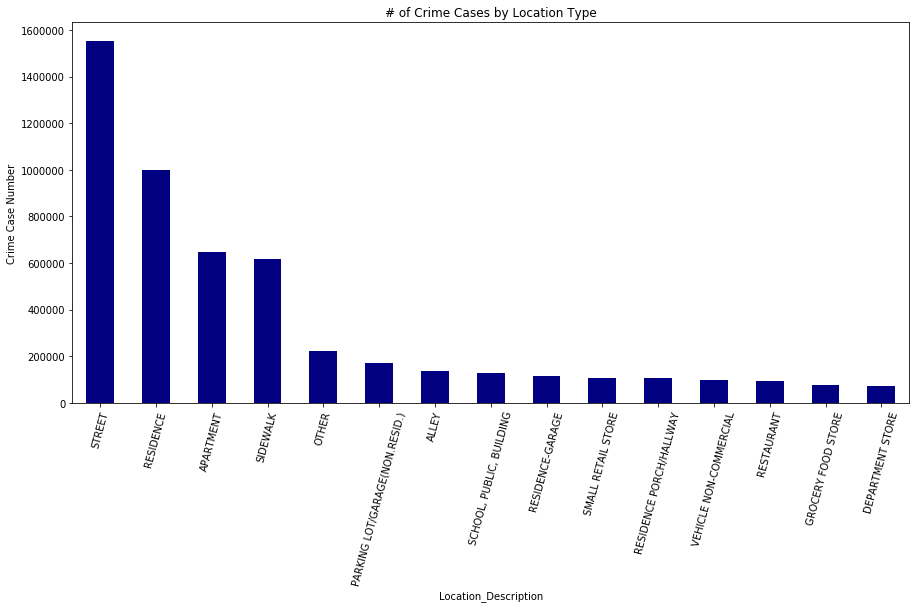

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_title('# of Crime Cases by Location Type')
ax.set_xlabel('Location Type')
ax.set_ylabel('Crime Case Number')
location_type_df1.plot(kind='bar', rot=75, ax=ax, color='navy')

### 4.2 Check the number of crime cases by time for the top 4 location types

In [21]:
df2 = df1.groupby([df1.index.to_period('H').hour, 'Location_Description'] ).count()['ID'].unstack(level=0)
from datetime import datetime
df2.columns = [datetime.strptime(str(col), '%H').strftime('%H:%M:%S') for col in df2.columns]

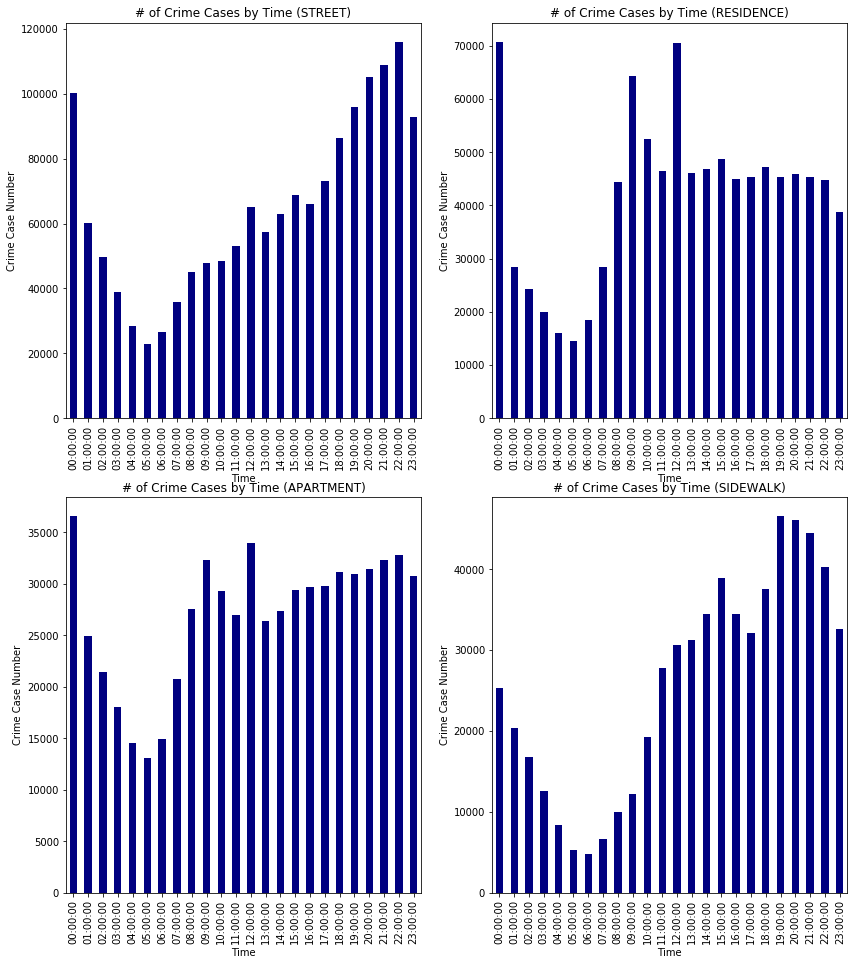

In [22]:
fig = plt.figure(figsize=(14,16))
ax1 = plt.subplot(2,2,1)
ax1.set_title('# of Crime Cases by Time (STREET)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Crime Case Number')
df2.loc['STREET',:].plot(kind='bar', color='navy', ax=ax1)

ax2 = plt.subplot(2,2,2)
ax2.set_title('# of Crime Cases by Time (RESIDENCE)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Crime Case Number')
df2.loc['RESIDENCE',:].plot(kind='bar', color='navy', ax=ax2)

ax3 = plt.subplot(2,2,3)
ax3.set_title('# of Crime Cases by Time (APARTMENT)')
ax3.set_xlabel('Time')
ax3.set_ylabel('Crime Case Number')
df2.loc['APARTMENT',:].plot(kind='bar', color='navy', ax=ax3)

ax4 = plt.subplot(2,2,4)
ax4.set_title('# of Crime Cases by Time (SIDEWALK)')
ax4.set_xlabel('Time')
ax4.set_ylabel('Crime Case Number')
df2.loc['SIDEWALK',:].plot(kind='bar', color='navy', ax=ax4)
plt.show()

### 4.3 Conclusions:
- Top 4 Location Types that are among the highest number of crime cases are STREET, RESIDENCE, APARTMENT, and SIDEWALK.
- Crime cases happen least between 4:00 - 6:00. For STREET and SIDEWALK, crime cases happen most betwen 20:00 and 23:00. For RESIDENCE and APARTMENT, they happen most on either around mid-night or around noon-time. 

# 5. Crimes Case vs Beat/District/Ward/Community Area
Question: which beat/district/ward/community areas are among the largest number of crime cases?

In [23]:
beat_df1 = df1['ID'].groupby(df1['Beat']).count().sort_values(ascending=False).head(15)

In [24]:
district_df1 = df1['ID'].groupby(df1['District']).count().sort_values(ascending=False).head(15)

In [25]:
ward_df1 = df1['ID'].groupby(df1['Ward']).count().sort_values(ascending=False).head(15)

In [26]:
comm_df1 = df1['ID'].groupby(df1['Community_Area']).count().sort_values(ascending=False).head(15)

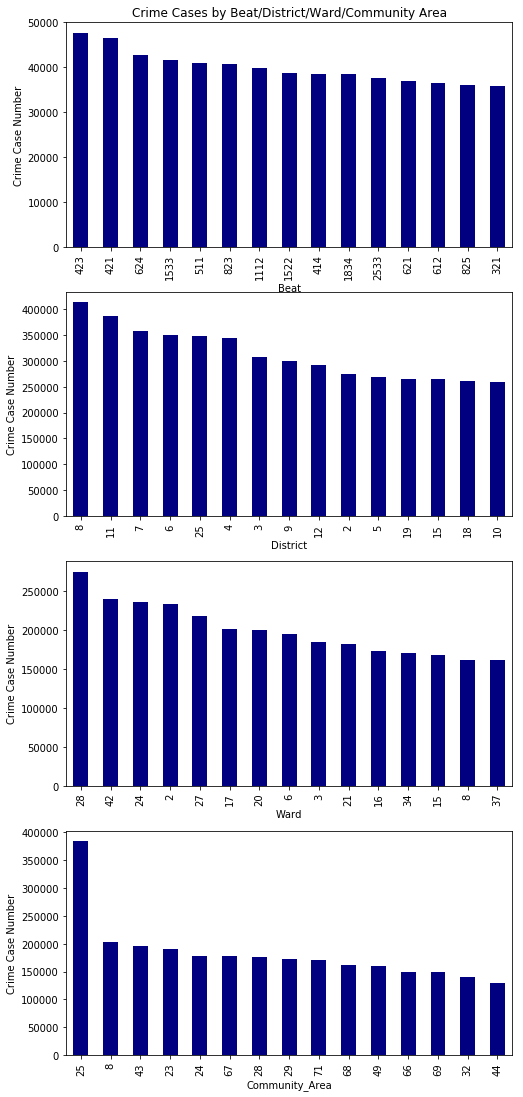

In [27]:
fig = plt.figure(figsize=(8,19))
ax1 = plt.subplot(4,1,1)
ax1.set_title('Crime Cases by Beat/District/Ward/Community Area')
#ax1.set_xlabel('Top Beat/District/Ward/Community Area')
ax1.set_ylabel('Crime Case Number')
beat_df1.plot(kind='bar', color='navy', ax=ax1)

ax2 = plt.subplot(4,1,2)
#ax2.set_title('Crime Cases by Beat/District/Ward/Community Area')
ax2.set_ylabel('Crime Case Number')
district_df1.plot(kind='bar', color='navy', ax=ax2)

ax3 = plt.subplot(4,1,3)
#ax3.set_title('Crime Cases by Beat/District/Ward/Community Area')
ax3.set_ylabel('Crime Case Number')
ward_df1.plot(kind='bar', color='navy', ax=ax3)

ax4 = plt.subplot(4,1,4)
#ax4.set_title('Crime Cases by Beat/District/Ward/Community Area')
ax4.set_ylabel('Crime Case Number')
comm_df1.plot(kind='bar', color='navy', ax=ax4)

plt.show()

### 5.1 Conclusions and Follow-ups
- Clearly the number of #25 Community Area is much higher than that for other community areas. It deserves further investigation on why this area is so high
- Please note that the numbers along X-axis represents codes for Beat/District/Ward/Community Area. Further we need to get the relevant names and their locations on the Chicago city map

# 6. Crime Cases vs FBI Classification
Question: what is the relationship between the number of crime cases and FBI classifications? Can we compare that with the national results?

In [28]:
#fbi_code_df1 = df1.groupby(['FBI_Code', 'Year']).count().sort_values(by=['FBI_Code','Year'], ascending=True)['ID']

In [29]:
fbi_code_df1 = df1.groupby('FBI_Code').count().sort_values(by='ID', ascending=False)['ID'].head(5)
fbi_code_df1

FBI_Code
06     1263980
08B     941145
14      689835
26      612597
18      593877
Name: ID, dtype: int64

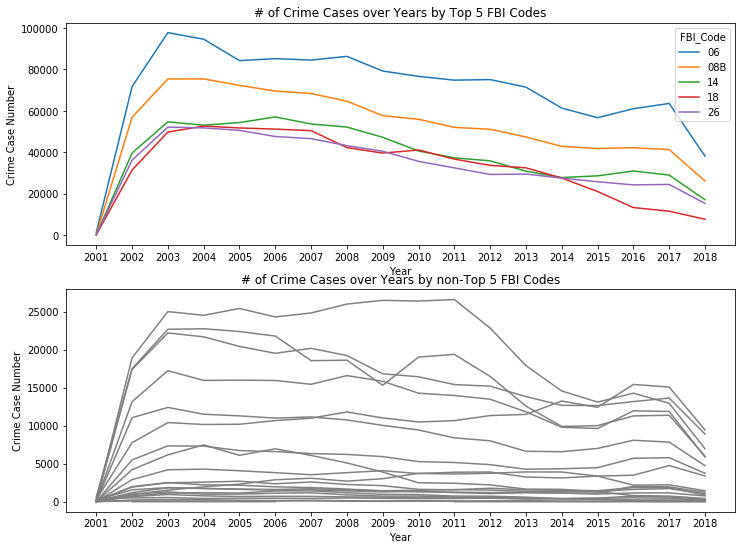

In [30]:
fig = plt.figure(figsize=(12,9))

ax1 = plt.subplot(2,1,1)            
ax1.set_title('# of Crime Cases over Years by Top 5 FBI Codes')
ax1.set_xlabel('Year')
ax1.set_ylabel('Crime Case Number')
xticks = list(range(2001,2019)) 

fbi_code_df2 = df1[df1['FBI_Code'].isin (fbi_code_df1.index)]
fbi_code_df2.head(5)
fbi_code_df2.groupby(['FBI_Code', 'Year']).count()['ID'].unstack(level=0).plot(ax=ax1, xticks=xticks)

ax2 = plt.subplot(2,1,2)            
ax2.set_title('# of Crime Cases over Years by non-Top 5 FBI Codes')
ax2.set_xlabel('Year')
ax2.set_ylabel('Crime Case Number')
fbi_code_df3 = df1[~df1['FBI_Code'].isin (fbi_code_df1.index)]
fbi_code_df3.groupby(['FBI_Code', 'Year']).count()['ID'].unstack(level=0).plot(ax=ax2, color='gray', legend=False, xticks=xticks)
plt.show()

### 6.1 Conclusions and Follow-ups
- The FBI codes of 06, 08B, 14, 18 and 26 are Top 5 classifications having the most crime cases
- The numbers of crime cases by Top 5 FBI Codes are going down over the years
- Please note that the FBI codes in the first graph is used. Further we need to get the relevant names and show them accordingly